<a href="https://colab.research.google.com/github/avani1998/early_detection_of_plant_disease/blob/main/ResNet-50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importing the required libraries

In [4]:
# ! pip install tensorflow-addons
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical,plot_model,save_img
from sklearn.model_selection import train_test_split
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# import tensorflow_addons as tfa
import tensorflow_datasets as tfds
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

### Loading the PlantVillage dataset using the TensorFlow-Datasets library

In [5]:
(ds_train, ds_val), ds_info = tfds.load(
    'plant_village',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
    with_info=True,
)

Creating a custom function to preprocess the dataset:

In [6]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
    tf.keras.layers.experimental.preprocessing.RandomContrast(0.2),
])

In [25]:
def preprocess_data(image, label):
    image = tf.image.resize(image, (256, 256))
    image = data_augmentation(image)
    image = tf.cast(image, tf.float32) / 255.0
    label = tf.one_hot(label, depth=ds_info.features['label'].num_classes)
    return image, label

Applying the preprocessing function to the training and validation sets:

In [26]:
train_ds = ds_train.map(preprocess_data, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_ds = ds_val.map(preprocess_data, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [27]:
# first = train_ds.take(20)
# image, label = list(first)[1]
# print(image)
# plt.imshow(image)
# print(label)
# print(image.shape)

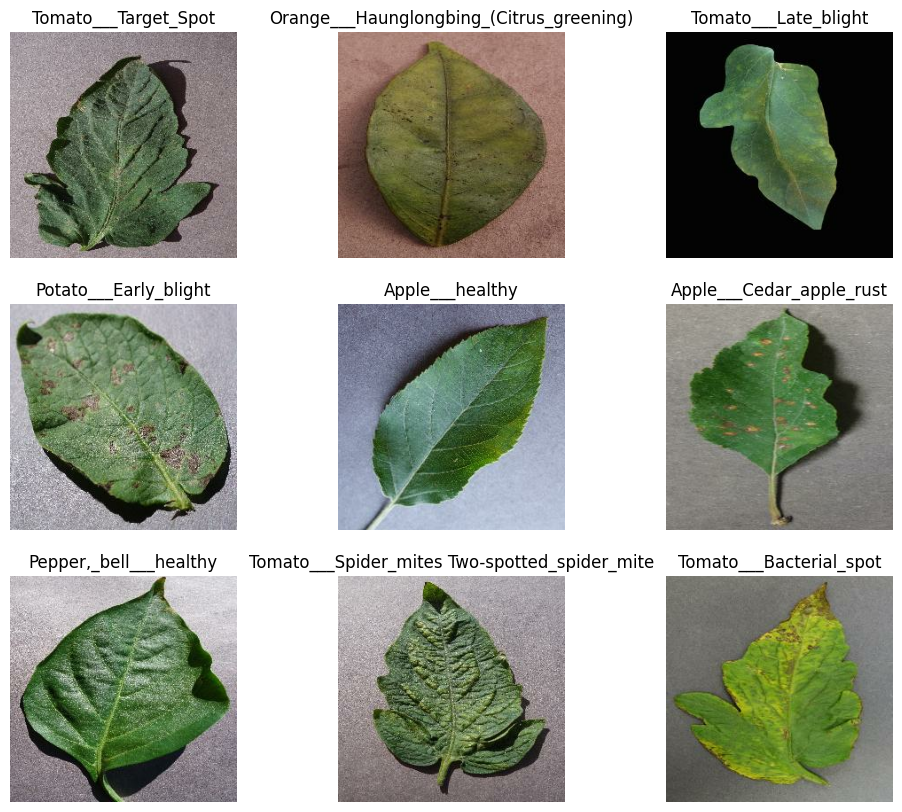

In [28]:
plt.figure(figsize=(12,10))
def plot_images(data):
    dataset= data.take(10)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        image,label=list(dataset)[i]
        plt.imshow(image)  # Scale the pixel values back to the original range
        plt.title(ds_info.features['label'].int2str(label))
        plt.axis("off")
    plt.show()
plot_images(ds_train)

# Training and resnet - 50

In [15]:
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           min_delta=0,
                           restore_best_weights=True)

In [ ]:
batch_size = 32
train_ds = train_ds.batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_ds = val_ds.batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
num_classes=38
num_epochs=50

In [ ]:
# Create a ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(
    'best_model.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    verbose=1
)

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Load the pre-trained ResNet-50 model without the top classification layer
base_model = ResNet50(weights=None, include_top=False, input_shape=(256, 256, 3))

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Add a new classification layer on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x) 

# Create the transfer learning model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_ds, validation_data=val_ds,batch_size=32, epochs=num_epochs, callbacks=[checkpoint_callback,early_stop])

# Evaluate the model
loss, accuracy = model.evaluate(val_ds)

Epoch 1/50
1358/1358 [==============================] - ETA: 0s - loss: 3.2657 - accuracy: 0.1670
Epoch 1: val_loss improved from inf to 3.05716, saving model to best_model.h5
1358/1358 [==============================] - 397s 283ms/step - loss: 3.2657 - accuracy: 0.1670 - val_loss: 3.0572 - val_accuracy: 0.2139
Epoch 2/50
1358/1358 [==============================] - ETA: 0s - loss: 2.9512 - accuracy: 0.2224
Epoch 2: val_loss improved from 3.05716 to 2.80192, saving model to best_model.h5
1358/1358 [==============================] - 384s 283ms/step - loss: 2.9512 - accuracy: 0.2224 - val_loss: 2.8019 - val_accuracy: 0.2506
Epoch 3/50
1358/1358 [==============================] - ETA: 0s - loss: 2.7011 - accuracy: 0.2684
Epoch 3: val_loss improved from 2.80192 to 2.55778, saving model to best_model.h5
1358/1358 [==============================] - 386s 284ms/step - loss: 2.7011 - accuracy: 0.2684 - val_loss: 2.5578 - val_accuracy: 0.3089
Epoch 4/50
1358/1358 [==============================]

In [ ]:
# model.summary()

In [ ]:
# plot_model(base_model,
#            to_file='reset50.png',
#            show_shapes=True,
#            show_dtype=True,
#            show_layer_names=True)

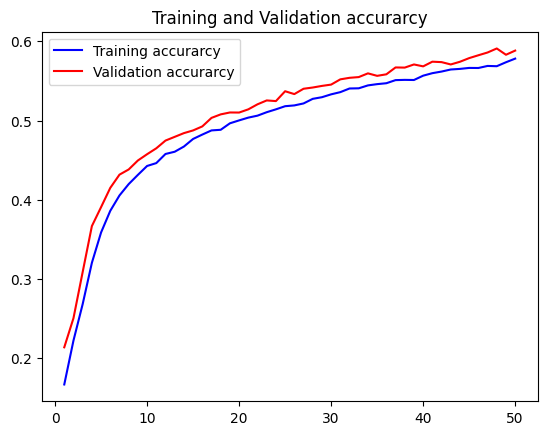

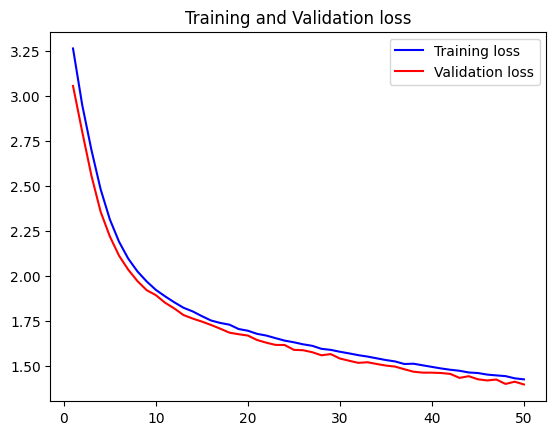

In [ ]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

# --------------------------------------------------------------------------------------------------------

## We increase the training batch size to 64. Maybe implement gradient descent. If batch size is too large increase learning rate. 

In [ ]:
def preprocess_data(image, label):
    image = tf.image.resize(image, (224, 224))
    image = data_augmentation(image)
    image = tf.cast(image, tf.float32) / 255.0
    label = tf.one_hot(label, depth=ds_info.features['label'].num_classes)
    return image, label

In [ ]:
train_ds = ds_train.map(preprocess_data, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_ds = ds_val.map(preprocess_data, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [ ]:
training_batch_size = 64
val_batch_size= 32
train_ds = train_ds.batch(training_batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_ds = val_ds.batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
num_classes=38
num_epochs=50

In [ ]:
# Create a ModelCheckpoint callback
checkpoint_callback_64 = ModelCheckpoint(
    'best_model_64.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    verbose=1
)

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Load the pre-trained ResNet-50 model without the top classification layer
base_model = ResNet50(weights=None, include_top=False, input_shape=(224, 224, 3))

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Add a new classification layer on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x) 

# Create the transfer learning model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_ds, validation_data=val_ds,batch_size=32, epochs=num_epochs, callbacks=[checkpoint_callback,early_stop])

# Evaluate the model
loss, accuracy = model.evaluate(val_ds)

Epoch 1/10
679/679 [==============================] - ETA: 0s - loss: 3.3270 - accuracy: 0.1526
Epoch 1: val_loss did not improve from 1.39511
679/679 [==============================] - 324s 469ms/step - loss: 3.3270 - accuracy: 0.1526 - val_loss: 3.1973 - val_accuracy: 0.2138
Epoch 2/10
602/679 [=========================>....] - ETA: 28s - loss: 3.0641 - accuracy: 0.2075

KeyboardInterrupt: ignored

In [ ]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

Reduce on Plateau

In [7]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.1,
                              patience=3,
                              min_lr=0.00001,
                              verbose=1,
                             cooldown=15)

In [8]:
def preprocess_data(image, label):
    image = tf.image.resize(image, (224, 224))
    image = data_augmentation(image)
    image = tf.cast(image, tf.float32) / 255.0
    label = tf.one_hot(label, depth=ds_info.features['label'].num_classes)
    return image, label

In [9]:
train_ds = ds_train.map(preprocess_data, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_ds = ds_val.map(preprocess_data, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [10]:
training_batch_size = 128
# val_batch_size= 32
train_ds = train_ds.batch(training_batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_ds = val_ds.batch(training_batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [11]:
num_classes=38
num_epochs=50

In [12]:
# Create a ModelCheckpoint callback
checkpoint_callback_64 = ModelCheckpoint(
    'best_model_64_reduce.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    verbose=1
)

In [16]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Load the pre-trained ResNet-50 model without the top classification layer
base_model = ResNet50(weights=None, include_top=False, input_shape=(224, 224, 3))

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Add a new classification layer on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x) 

# Create the transfer learning model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_reduced = model.fit(train_ds, validation_data=val_ds,batch_size=32, epochs=num_epochs, callbacks=[checkpoint_callback_64,early_stop,reduce_lr])

# Evaluate the model
loss, accuracy = model.evaluate(val_ds)

Epoch 1/50
340/340 [==============================] - ETA: 0s - loss: 3.3489 - accuracy: 0.1441
Epoch 1: val_loss improved from inf to 3.24985, saving model to best_model_64_reduce.h5
340/340 [==============================] - 303s 850ms/step - loss: 3.3489 - accuracy: 0.1441 - val_loss: 3.2498 - val_accuracy: 0.2232 - lr: 0.0010
Epoch 2/50
340/340 [==============================] - ETA: 0s - loss: 3.1162 - accuracy: 0.2131
Epoch 2: val_loss improved from 3.24985 to 2.98019, saving model to best_model_64_reduce.h5
340/340 [==============================] - 265s 779ms/step - loss: 3.1162 - accuracy: 0.2131 - val_loss: 2.9802 - val_accuracy: 0.2305 - lr: 0.0010
Epoch 3/50
340/340 [==============================] - ETA: 0s - loss: 2.9115 - accuracy: 0.2297
Epoch 3: val_loss improved from 2.98019 to 2.81747, saving model to best_model_64_reduce.h5
340/340 [==============================] - 257s 755ms/step - loss: 2.9115 - accuracy: 0.2297 - val_loss: 2.8175 - val_accuracy: 0.2508 - lr: 0.0

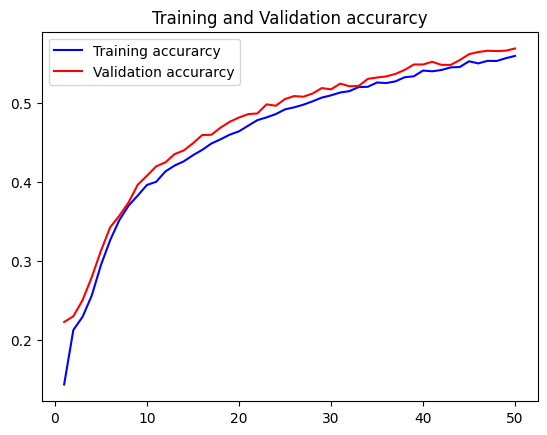

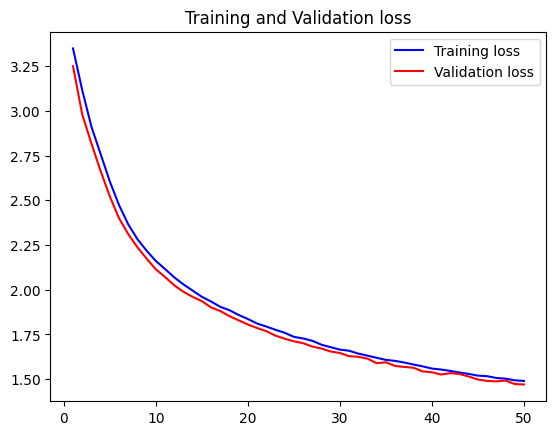

In [17]:
acc=history_reduced.history['accuracy']
val_acc=history_reduced.history['val_accuracy']
loss=history_reduced.history['loss']
val_loss=history_reduced.history['val_loss']

epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

## change activation fucntion to sigmoid

In [18]:
def preprocess_data_sigmoid(image, label):
    image = tf.image.resize(image, (224, 224))
    image = data_augmentation(image)
    image = tf.cast(image, tf.float32) / 255.0
    label = tf.one_hot(label, depth=ds_info.features['label'].num_classes)
    return image, label

In [19]:
train_ds = ds_train.map(preprocess_data_sigmoid, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_ds = ds_val.map(preprocess_data_sigmoid, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [20]:
training_batch_size = 64
# val_batch_size= 32
train_ds = train_ds.batch(training_batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_ds = val_ds.batch(training_batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [21]:
num_classes=38
num_epochs=50

In [22]:
# Create a ModelCheckpoint callback
checkpoint_callback_64 = ModelCheckpoint(
    'best_model_64_reduce_sigmoid.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    verbose=1
)

In [24]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Load the pre-trained ResNet-50 model without the top classification layer
base_model = ResNet50(weights=None, include_top=False, input_shape=(224, 224, 3))

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Add a new classification layer on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='sigmoid')(x)
predictions = Dense(num_classes, activation='softmax')(x) 

# Create the transfer learning model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_reduced = model.fit(train_ds, validation_data=val_ds,batch_size=64, epochs=num_epochs, callbacks=[checkpoint_callback_64,early_stop,reduce_lr])

# Evaluate the model
loss, accuracy = model.evaluate(val_ds)

Epoch 1/50
679/679 [==============================] - ETA: 0s - loss: 3.2056 - accuracy: 0.1794
Epoch 1: val_loss improved from inf to 3.08424, saving model to best_model_64_reduce_sigmoid.h5
679/679 [==============================] - 292s 424ms/step - loss: 3.2056 - accuracy: 0.1794 - val_loss: 3.0842 - val_accuracy: 0.1893 - lr: 0.0010
Epoch 2/50
679/679 [==============================] - ETA: 0s - loss: 3.0256 - accuracy: 0.2092
Epoch 2: val_loss improved from 3.08424 to 2.93543, saving model to best_model_64_reduce_sigmoid.h5
679/679 [==============================] - 292s 430ms/step - loss: 3.0256 - accuracy: 0.2092 - val_loss: 2.9354 - val_accuracy: 0.2178 - lr: 0.0010
Epoch 3/50
679/679 [==============================] - ETA: 0s - loss: 2.8821 - accuracy: 0.2340
Epoch 3: val_loss improved from 2.93543 to 2.78616, saving model to best_model_64_reduce_sigmoid.h5
679/679 [==============================] - 259s 382ms/step - loss: 2.8821 - accuracy: 0.2340 - val_loss: 2.7862 - val_ac

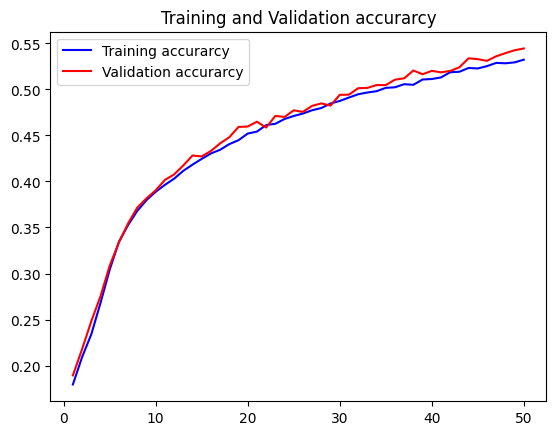

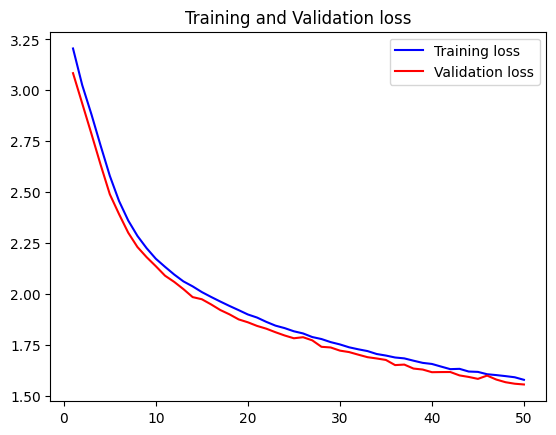

In [25]:
acc=history_reduced.history['accuracy']
val_acc=history_reduced.history['val_accuracy']
loss=history_reduced.history['loss']
val_loss=history_reduced.history['val_loss']

epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()